# Example: Let's Compute and Analyze the Covariance Matrix for our Dataset
In this example, we will compute the covariance matrix for our dataset of equity returns, and then analyze some interesting entries in the covariance matrix.

> __Learning Objectives:__
>
> By the end of this example, you should be able to:
> * __Compute empirical covariance matrices__: Calculate covariance matrices from historical return data using matrix operations and verify results against built-in functions.
> * __Analyze covariance relationships__: Examine covariance and correlation between specific asset pairs and interpret their relationships through data visualization.
> * __Understand covariance implications__: Discuss the meaning of positive and negative covariances for portfolio construction and risk management.

This is going to be interesting, so let's get started!
___

## Setup, Data, and Prerequisites
First, we set up the computational environment by including the `Include.jl` file and loading any needed resources.

>__Include:__ The [`include(...)` command](https://docs.julialang.org/en/v1/base/base/#include) evaluates the contents of the input source file, `Include.jl`, in the notebook's global scope. The `Include.jl` file sets paths, loads required external packages, etc. For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/). 

Let's set up our code environment:

In [3]:
include(joinpath(@__DIR__, "Include.jl")); # include the Include.jl file

For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/) and the [VLQuantitativeFinancePackage.jl documentation](https://github.com/varnerlab/VLQuantitativeFinancePackage.jl). 

### Data
We gathered daily open-high-low-close (OHLC) data for each firm in the [S&P500](https://en.wikipedia.org/wiki/S%26P_500) from `01-03-2014` until `12-31-2024`, along with data for several exchange-traded funds and volatility products during that time period. 

Let's load the `original_dataset::DataFrame` by calling [the `MyTrainingMarketDataSet()` function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/data/#VLQuantitativeFinancePackage.MyTrainingMarketDataSet) and remove firms that do not have the maximum number of trading days. The cleaned dataset $\mathcal{D}$ will be stored in the `dataset` variable.

In [6]:
original_dataset = MyTrainingMarketDataSet() |> x-> x["dataset"];

Not all tickers in our dataset have the maximum number of trading days for various reasons, such as acquisition or delisting events. Let's collect only those tickers with the maximum number of trading days.

First, let's compute the number of records for a firm that we know has the maximum value, e.g., `AAPL`, and save that value in the `maximum_number_trading_days::Int64` variable:

In [8]:
maximum_number_trading_days = original_dataset["AAPL"] |> nrow;

Now, let's iterate through our data and collect only tickers with `maximum_number_trading_days` records. Save that data in the `dataset::Dict{String,DataFrame}` variable:

In [10]:
dataset = let

    # initialize -
    dataset = Dict{String, DataFrame}();

    # iterate through the dictionary; we can't guarantee a particular order
    for (ticker, data) ∈ original_dataset  # we get each (K, V) pair!
        if (nrow(data) == maximum_number_trading_days) # check if ticker has maximum trading days
            dataset[ticker] = data;
        end
    end
    dataset; # return
end;

Next, let's get a list of the firms in our cleaned dataset and sort them alphabetically. We store the sorted firm ticker symbols in the `list_of_tickers::Array{String,1}` variable:

In [12]:
list_of_tickers = keys(dataset) |> collect |> sort; # list of firm "ticker" symbols in alphabetical order

Now, let's load the GBM parameters that we computed in the previous example:

In [14]:
parameters_df = let

    # load -
    df = CSV.read(joinpath(_PATH_TO_DATA,"SAGBM-Parameters-Fall-2025.csv"), DataFrame);
    df; # return
end;

__Reminder:__ What's in the `parameters_df::DataFrame` variable?

In [16]:
parameters_df

Row,ticker,drift,t,lower_bound_drift,upper_bound_drift,volatility
,String7,Float64,Float64,Float64,Float64,Float64
1,A,0.147468,1.96,0.145161,0.149774,0.231426
2,AAL,-0.141294,1.96,-0.1436,-0.138988,0.454992
3,AAP,-0.0481021,1.96,-0.0504085,-0.0457958,0.342562
4,AAPL,0.24271,1.96,0.240403,0.245016,0.234474
5,ABBV,0.116,1.96,0.113693,0.118306,0.242938
6,ABT,0.123083,1.96,0.120777,0.125389,0.199723
7,ACN,0.151012,1.96,0.148706,0.153319,0.214367
8,ADBE,0.224401,1.96,0.222094,0.226707,0.276273
9,ADI,0.146449,1.96,0.144142,0.148755,0.259329


Finally, let's specify some constants that we will use in our analysis. Check out the comments for details on the constants, their permissible values, units, etc.

In [18]:
T = 252; # number of trading days in a year
Δt = (1/T); # time step (1 trading day, in years)

___

## Task 1: Compute the Empirical Covariance Matrix
In this task, let's compute the empirical covariance matrix $\hat{\mathbf{\Sigma}}$ for our dataset $\mathcal{D}$ using code that we write ourselves (we'll never do this in practice, but it's a good exercise). The empirical covariance matrix is given by:
$$
\hat{\mathbf{\Sigma}} = \frac{1}{n-1}\tilde{\mathbf{X}}^{\top}\tilde{\mathbf{X}}
$$
where $\tilde{\mathbf{X}}$ is the centered data matrix:
$$
\tilde{\mathbf{X}} = \mathbf{X} - \mathbf{1}\mathbf{m}^{\top}
$$
where $\mathbf{1} \in \mathbb{R}^{n}$ is a vector of ones, and $\mathbf{1}\mathbf{m}^{\top}$ creates an $n \times m$ matrix where each row is identical and contains the __returns__ on the columns. 

> __Outer product:__ The $\mathbf{1}\mathbf{m}^{\top}$ is an example of an outer product. The [outer product](https://en.wikipedia.org/wiki/Outer_product) of two vectors $\mathbf{a} \in \mathbb{R}^{n}$ and $\mathbf{b} \in \mathbb{R}^{m}$ is the $n \times m$ matrix $\mathbf{a}\mathbf{b}^{\top}$. Each element of the outer product is computed as $(\mathbf{a}\mathbf{b}^{\top})_{ij} = a_i b_j$. 

Let's start by constructing the data matrix $\mathbf{X} \in\mathbb{R}^{n \times m}$ where each row $k$ contains the __returns__ for all $m$ firms at time period $k$. To compute the returns, we [use the `log_growth_matrix(...)` function from the `VLQuantitativeFinancePackage.jl` package](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.log_growth_matrix) and multiply by the time step $\Delta{t}$. 

We store the __return__ data in the `X::Array{Float64,2}` variable:

In [21]:
X = log_growth_matrix(dataset, list_of_tickers) |> x-> *(x, Δt) # using return NOT growth rate

2766×424 Matrix{Float64}:
 -0.00348236    0.0249248    -0.0113928    …   0.000975772  -0.00398915
  0.0111756     0.00425196    0.00552534      -0.00318567    0.00391456
  0.013147      0.00339523    2.13017e-5       0.00472619   -0.0102438
  0.00256518    0.0684917     0.00671489       0.0125369    -0.00146122
  0.0072067     0.0102365     0.0131716       -0.00860597    0.0174726
  0.00243583   -0.0157295    -0.00314595   …  -0.00757844   -0.012366
  0.011352     -0.00191965    0.0192291       -0.00705099   -0.00432381
  0.00812185    0.00402184    0.00757178       0.0176581    -0.000546902
  0.00520989    0.00664336    0.000425632     -0.00848001    0.00570572
  0.00484189    0.0243237     0.0037007        0.01142      -0.00569943
 -0.00173678    0.0193258     0.00399897   …   0.0377312    -0.0119394
  0.00540798    0.014338     -0.00931651       0.0179453     0.00135132
 -0.0188057     0.00549939   -0.0119692       -0.0263852     0.00557984
  ⋮                                       

Next, let's compute the mean returns for each firm and store them in the `m::Array{Float64,1}` variable:

In [23]:
m = mean(X, dims=1) |> vec # mean returns for each firm

424-element Vector{Float64}:
  0.00043152690397797543
 -0.00014695410782087574
 -0.00031710102271930227
  0.0009238140812477853
  0.00044105742821765466
  0.0003886896526928266
  0.0005289761752874104
  0.000728454706044617
  0.0005265024709424276
  5.61853564860157e-5
  0.0004647400737098557
  0.0006499480204724478
  0.0003337563241435573
  ⋮
  0.0006865050916225521
 -0.00017058887872877418
 -4.066306727918652e-5
 -0.0002980758699105983
  0.0003246107481543654
  2.6916182694995662e-5
 -0.0003392763144159303
  0.0004385755770372527
  0.00020645030708843503
  0.0007130714183989559
  0.00021701413350653826
  0.0005858730432623264

Now, let's form the centered data matrix $\tilde{\mathbf{X}}$ by subtracting the mean returns from each row of the data matrix $\mathbf{X}$. We store the centered data in the `X_centered::Array{Float64,2}` variable:

In [25]:
r, c = size(X)
ones_vector = ones(r)
⊗(ones_vector, m) # outer product of ones_vector and m

2766×424 Matrix{Float64}:
 0.000431527  -0.000146954  -0.000317101  …  0.000217014  0.000585873
 0.000431527  -0.000146954  -0.000317101     0.000217014  0.000585873
 0.000431527  -0.000146954  -0.000317101     0.000217014  0.000585873
 0.000431527  -0.000146954  -0.000317101     0.000217014  0.000585873
 0.000431527  -0.000146954  -0.000317101     0.000217014  0.000585873
 0.000431527  -0.000146954  -0.000317101  …  0.000217014  0.000585873
 0.000431527  -0.000146954  -0.000317101     0.000217014  0.000585873
 0.000431527  -0.000146954  -0.000317101     0.000217014  0.000585873
 0.000431527  -0.000146954  -0.000317101     0.000217014  0.000585873
 0.000431527  -0.000146954  -0.000317101     0.000217014  0.000585873
 0.000431527  -0.000146954  -0.000317101  …  0.000217014  0.000585873
 0.000431527  -0.000146954  -0.000317101     0.000217014  0.000585873
 0.000431527  -0.000146954  -0.000317101     0.000217014  0.000585873
 ⋮                                        ⋱               
 0.00

In [26]:
X_centered = let 
    r, c = size(X)
    ones_vector = ones(r)
    X̃ = X .- ⊗(ones_vector, m);
end

2766×424 Matrix{Float64}:
 -0.00391389    0.0250717    -0.0110757    …   0.000758758  -0.00457502
  0.0107441     0.00439892    0.00584244      -0.00340269    0.00332868
  0.0127155     0.00354218    0.000338403      0.00450918   -0.0108297
  0.00213365    0.0686387     0.00703199       0.0123199    -0.0020471
  0.00677517    0.0103835     0.0134887       -0.00882298    0.0168867
  0.00200431   -0.0155826    -0.00282885   …  -0.00779546   -0.0129519
  0.0109205    -0.00177269    0.0195462       -0.00726801   -0.00490968
  0.00769032    0.0041688     0.00788889       0.0174411    -0.00113277
  0.00477837    0.00679031    0.000742733     -0.00869703    0.00511985
  0.00441036    0.0244706     0.00401781       0.011203     -0.00628531
 -0.00216831    0.0194727     0.00431607   …   0.0375142    -0.0125253
  0.00497645    0.0144849    -0.00899941       0.0177283     0.000765442
 -0.0192373     0.00564634   -0.0116521       -0.0266022     0.00499396
  ⋮                                       

Finally, let's compute the empirical covariance matrix $\hat{\mathbf{\Sigma}}$ and store it in the

In [28]:
Σ̂ = let 
   (r,c) = size(X_centered)
   Σ = (1/(r-1)) * (X_centered' * X_centered)
   Σ*T; # return
end

424×424 Matrix{Float64}:
 0.0535771   0.032397    0.0212982  …  0.0355662   0.0280938   0.0266666
 0.032397    0.207093    0.0431437     0.051429    0.0689041   0.0280481
 0.0212982   0.0431437   0.117391      0.0308539   0.037867    0.019717
 0.0229702   0.0312627   0.0163174     0.032633    0.0201827   0.022609
 0.0179206   0.0176175   0.0158407     0.0157326   0.0168026   0.0185472
 0.0244078   0.0195811   0.0145372  …  0.023159    0.0167416   0.0221966
 0.025643    0.0334402   0.0218931     0.0313218   0.0280694   0.023824
 0.0294242   0.02952     0.0185233     0.0369478   0.0198333   0.0262802
 0.0297618   0.0458278   0.0231343     0.0433011   0.0335821   0.0233085
 0.0169025   0.0325409   0.0206063     0.0219846   0.0327002   0.0131991
 0.0208802   0.0329941   0.0206376  …  0.0265633   0.0266024   0.0205401
 0.0372172   0.0505186   0.0249531     0.0483949   0.0345518   0.0295573
 0.0106321   0.0118731   0.0131235     0.0093745   0.0098168   0.0125213
 ⋮                           

### Visualize the Covariance Matrix
Let's create a heatmap of the covariance matrix to visualize the relationships between assets in the subset at once. This provides a quick overview of which assets are highly correlated (bright colors) versus uncorrelated or negatively correlated (darker colors).

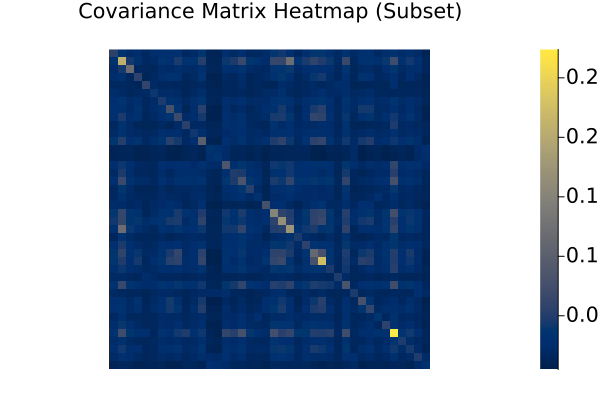

In [30]:
let
    # select a subset of tickers for better visualization (up to 40)
    n_show = min(40, length(list_of_tickers));
    subset_Σ̂ = Σ̂[1:n_show, 1:n_show];
    
    # create heatmap
    heatmap(subset_Σ̂, 
        xticks=false, 
        yticks=false, 
        axis=false,
        title="Covariance Matrix Heatmap (Subset)", 
        color=:cividis,
        aspect_ratio=:equal,
        yflip=true,
        colorbar_fontsize=8)
end

### Check: How does our answer compare to the built-in `cov(...)` function?
We should almost always buy versus build, i.e., use built-in functions versus writing our own. Let's compare our answer to [the built-in `cov(...)` function](https://docs.julialang.org/en/v1/stdlib/Statistics/#Statistics.cov).

In [32]:
Σ = let
    R = log_growth_matrix(dataset, list_of_tickers) |> x-> *(x, Δt); # we use the return!
    Σ = cov(R, dims=1)
    Σ*T;
end

424×424 Matrix{Float64}:
 0.0535771   0.032397    0.0212982  …  0.0355662   0.0280938   0.0266666
 0.032397    0.207093    0.0431437     0.051429    0.0689041   0.0280481
 0.0212982   0.0431437   0.117391      0.0308539   0.037867    0.019717
 0.0229702   0.0312627   0.0163174     0.032633    0.0201827   0.022609
 0.0179206   0.0176175   0.0158407     0.0157326   0.0168026   0.0185472
 0.0244078   0.0195811   0.0145372  …  0.023159    0.0167416   0.0221966
 0.025643    0.0334402   0.0218931     0.0313218   0.0280694   0.023824
 0.0294242   0.02952     0.0185233     0.0369478   0.0198333   0.0262802
 0.0297618   0.0458278   0.0231343     0.0433011   0.0335821   0.0233085
 0.0169025   0.0325409   0.0206063     0.0219846   0.0327002   0.0131991
 0.0208802   0.0329941   0.0206376  …  0.0265633   0.0266024   0.0205401
 0.0372172   0.0505186   0.0249531     0.0483949   0.0345518   0.0295573
 0.0106321   0.0118731   0.0131235     0.0093745   0.0098168   0.0125213
 ⋮                           

### Check: Can we independently verify that our covariance matrix is approximately correct?
Yes! There are two(ish) ways that we can do this.

First, we can check that the diagonal elements of the covariance matrix $\hat{\mathbf{\Sigma}}$ are approximately equal to the square of the volatility estimates that we computed in the previous examples. 

In [34]:
let
    # initialize -
    ticker_to_check = "AMD";
    i = findfirst(x-> x==ticker_to_check, list_of_tickers);
    σ_ii = sqrt(Σ̂[i,i]); # estimated volatility for ticker_to_check

    # what did we compute previously?
    σ_ii_previous = parameters_df[i, :volatility];
    
    # compute the difference -
    difference = abs(σ_ii - σ_ii_previous);
    println("σ_ii = $(σ_ii), previous = $(σ_ii_previous), abs(difference) = $difference")
end

σ_ii = 0.47428270674542305, previous = 0.47419696459399574, abs(difference) = 8.57421514273149e-5


The second method is even cooler! Let's check that the diagonal elements of the covariance matrix $\hat{\mathbf{\Sigma}}$ are approximately equal to the square of the __implied volatility__ estimates from the market!

> __Implied Volatility:__ The [implied volatility](https://en.wikipedia.org/wiki/Implied_volatility) is the market's forecast of a likely movement in a security's price. In other words, it's the volatility "implied" by the market price of an option based on an option pricing model (e.g., the [Black-Scholes model](https://en.wikipedia.org/wiki/Black%E2%80%93Scholes_model) or [Binomial model](https://en.wikipedia.org/wiki/Binomial_options_pricing_model)). 

> __How can we use it?__ The implied volatility represents one-standard deviation movement in the price of the underlying security over the next year. Therefore, if we square the implied volatility, we get an estimate of the variance of the security's returns over the next year. This is exactly what the diagonal elements of the covariance matrix represent!

Let's pop out to the market, and look at the implied volatility for a few firms. The implied volatility is often equal to or larger than the historical volatility (the diagonal elements of the covariance matrix we just computed).

___

## Task 2: Analyze the Covariance Matrix
In this task, let's pick out some interesting entries in the covariance matrix and analyze them. In particular, let's pick two tickers and see if their covariance is positive or negative, and then plot their growth rates to see if the data supports our findings.

Let's start by picking two tickers from our dataset. We store the ticker symbols in the `ticker_1::String` and `ticker_2::String` variables:

In [37]:
ticker_1 = "QQQ"; # select a ticker in our dataset
ticker_2 = "SPY"; # select a second ticker in our dataset

Next, let's get the data from our covariance matrix for our two tickers, and look at some values.

In [39]:
let
    i = findfirst(x-> x==ticker_1, list_of_tickers);
    j = findfirst(x-> x==ticker_2, list_of_tickers);
    covariance_ij = Σ̂[i,j];
    σᵢ = sqrt(Σ̂[i,i]);
    σⱼ = sqrt(Σ̂[j,j]);
    correlation_ij = covariance_ij / (σᵢ * σⱼ);


    println("Covariance between $ticker_1 and $ticker_2 is approximately $covariance_ij")
    println("Correlation between $ticker_1 and $ticker_2 is approximately $correlation_ij")
end

Covariance between QQQ and SPY is approximately 0.020719582444817572
Correlation between QQQ and SPY is approximately 0.9172495603783957


Let's plot the returns for our two tickers to see if the data supports our findings.

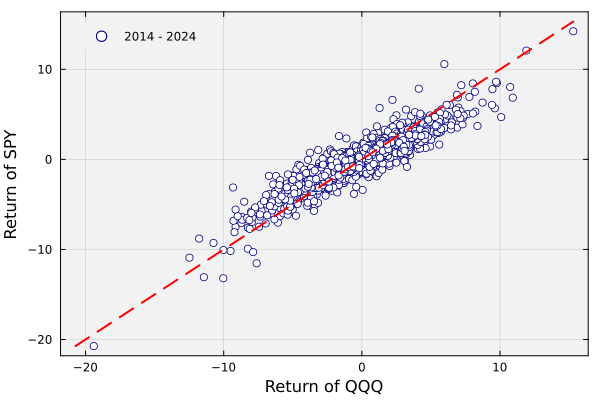

In [41]:
let

    # initialize -
    i = findfirst(x-> x==ticker_1, list_of_tickers);
    j = findfirst(x-> x==ticker_2, list_of_tickers);
    G = log_growth_matrix(dataset, list_of_tickers); # growth*Δt = return
    r, c = size(G); # rows, columns
    X = Array{Float64, 2}(undef, r, 2); # initialize matrix to hold growth rates for two tickers

    # collect the data -
    for t ∈ 1:r
        X[t,1] = G[t,i]; # growth rate for ticker_1
        X[t,2] = G[t,j]; # growth rate for ticker_2
    end

    # make xy-line -
    # Create x=y line data
    min_val = min(minimum(X[:,1]), minimum(X[:,2]))
    max_val = max(maximum(X[:,1]), maximum(X[:,2]))
    xy_line = [min_val, max_val]

    # plot -
    scatter(X[:,1], X[:,2], xlabel="Return of $ticker_1", ylabel="Return of $ticker_2", label="2014 - 2024", 
        c=:white, msc=:navy)
    plot!(xy_line, xy_line, color=:red, linestyle=:dash, label="", lw=2)
    plot!(bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent);
end

### Discussion Questions
Why do we care about covariance (and correlation)?
1. What does it mean if two assets have positive covariance? Negative covariance? 
2. Is it a good thing to have assets with negative covariance in your portfolio? Why or why not?

___

## Save the covariance matrix
Finally, let's save the covariance matrix to [a JLD2 file](https://github.com/JuliaIO/JLD2.jl) for future use. We will save the covariance matrix and the list of tickers in the cleaned dataset (to establish the order of the covariance matrix) in the `Covariance-Return-Training-Fall-2025.jld2` file.

In [45]:
let

    # initialize -
    path_to_save = joinpath(_PATH_TO_DATA, "Covariance-Return-Training-Fall-2025.jld2");
    save(path_to_save, Dict(
        "covariance_matrix" => Σ̂,
        "list_of_tickers" => list_of_tickers
    ));
    println("Covariance matrix and list of tickers saved to $path_to_save") # let the user know this worked.
end

Covariance matrix and list of tickers saved to /Users/jeffreyvarner/Desktop/julia_work/CHEME-5660-Fall-2025/CHEME-5660-CourseRepository-Fall-2025/lectures/week-6/L6b/data/Covariance-Return-Training-Fall-2025.jld2


## Summary
In this example, we computed the empirical covariance matrix for a portfolio of equities using historical return data. 

> __Key Takeaways:__
> * __Covariance matrix computation__: The empirical covariance matrix is computed as $\hat{\mathbf{\Sigma}} = \frac{1}{n-1}\tilde{\mathbf{X}}^{\top}\tilde{\mathbf{X}}$ where $\tilde{\mathbf{X}}$ is the centered data matrix obtained by subtracting mean returns, and can be verified against built-in functions, historical volatility and forward-looking implied volatility estimates.
> * __Covariance analysis__: Positive covariance indicates assets that tend to move together, while negative covariance shows assets that move oppositely, which has implications for portfolio diversification.
> * __Visualization insights__: Plotting returns of asset pairs provides visual confirmation of their covariance relationships and helps in understanding market dynamics.

__TL;DR__ We need the covariance for our simulations, but it also gives us some principled way to select tickers (may not want highly correlated tickers in our portfolio)

___


## Disclaimer and Risks
__This content is offered solely for training and informational purposes__. No offer or solicitation to buy or sell securities or derivative products or any investment or trading advice or strategy is made, given, or endorsed by the teaching team. 

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance. Only risk capital that is not required for living expenses should be used.

__You are fully responsible for any investment or trading decisions you make__. Such decisions should be based solely on evaluating your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.

___